In [1]:
import os
import torch
import torchvision

import statistics
import h5py
import copy
import cv2
import deepdish as dd

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from sklearn.metrics import roc_auc_score
from skimage import measure

import sklearn.metrics as metrics
import numpy as np
from sklearn.metrics import roc_curve, auc, jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


import tempfile
import time
import pickle as pkl;

In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/

In [2]:
n_epochs = 10
patience_limit = 20
patience = 0
batch_size_train = 1 # use 1 to make valid easier
batch_size_test = 1
learning_rate = 0.0005
momentum = 0.1
log_interval = 31
tt_factor = 0.8
orientation = 'AP'
num_imgs = 5000

disease_to_train = 'all_diseases_all_imgs'
model_path = './data/saved_models/' + disease_to_train + '.pth'

random_seed = 1
#torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
''' 
    NOTES: 
    - it's "No Finding" not "No findings"
    - it's "Pleural_Thickening" not "Pleural_thickening"
    - it's not "Nodule Mass", but rather "Nodule" and "Mass" separately
'''
disease_map = {"Atelectasis" : 0, "Consolidation" : 1, "Infiltration" : 2, "Pneumothorax": 3, "Edema": 4,
               "Emphysema": 5, "Fibrosis": 6, "Effusion" : 7, "Pneumonia" : 8, "Pleural_Thickening" : 9,
               "Cardiomegaly" : 10, "Nodule" : 11, "Mass" : 12, "Hernia" : 13, "No Finding" : 14 }


In [4]:
dis_small_map = {'Cardiomegaly': 0, 'Effusion': 1, 'Mass': 2, 'Nodule': 3, 'Atelectasis': 4, 'No Finding': 5}

In [5]:
class GetLoader_w_val(torch.utils.data.Dataset):
    '''
        NOTE: I hardcoded this one a bit, basically splits validation set in half and gives it to test set
    
        Params: data - the data dictionary
                view - the orientation you want to look at
                diseases - the diseases you would like to look at
                num_imgs - the number of images of each disease you would like
                factor - the ratio of training and testing data
                typ - 0 for training, 1 for testing
    '''
    def __init__(self, data, view, diseases, num_imgs, factor, typ, transforms=None):
        
        #private data
        self.root = os.path.join('data/sorted_images',)
        self.data = data # dict object
        self.transforms = transforms
        self.len_data = 0
        datalist = []
        
        #Creating the datalist
        for i in range(len(diseases)):                
            
            if len(data[view][diseases[i]]) <= num_imgs: #if the folder has less images than the desired number of images
                if typ == 0:
                    start = 0
                    end = int(len(data[view][diseases[i]])*factor)
                elif typ == 1:
                    start = int(len(data[view][diseases[i]])*factor)
                    end = int(len(data[view][diseases[i]])*factor + len(data[view][diseases[i]])*(1-factor) / 2)
                else:
                    start = int(len(data[view][diseases[i]])*factor + len(data[view][diseases[i]])*(1-factor) / 2)
                    end = -1
            else:
                if typ == 0:
                    start = 0
                    end = int(num_imgs*factor)
                elif typ == 1:
                    start = int(num_imgs*factor)
                    end = int(num_imgs*factor + num_imgs*(1-factor) / 2)
                else:
                    start = int(num_imgs*factor + num_imgs*(1-factor) / 2)
                    end = num_imgs
                    
            #print('dis: ', diseases[i], ', type: ', typ, ', start: ', start, ', end:', end)
            print('disease: ', diseases[i], 'num images used: ', min(len(data[view][diseases[i]]), num_imgs))
            
            #class_weights[disease_map[diseases[i]]] = num_imgs / min(len(data[view][diseases[i]]), num_imgs)
            
            datalist.append(self.data[view][diseases[i]][start:end])
        
        for item in datalist:
            self.len_data += len(item)
        
        
        self.img_paths = []
        self.img_labels = []
        
        for dis in datalist:
            for data in dis:
                #creating the image path
                data['img_path'] = os.path.join(self.root, data['classes'][0], view, data['img_name'])            
                diseases_item = data['classes']

                one_hot = np.zeros(6)
                for d in diseases_item:
                    if d in diseases:
                        hot_index = dis_small_map[d]
                        one_hot[hot_index] = 1

                self.img_paths.append(data['img_path'])
                self.img_labels.append(torch.Tensor(one_hot))


    def __getitem__(self, item):
        
        img_path, img_label = self.img_paths[item], self.img_labels[item]
  
        # TODO: fix this hot fix -> recreate data object with underscore in name
        img_path = img_path.replace('No Finding', 'No_Finding')
        try:
            img = Image.open(img_path).convert('RGB')
        except:
            img_path = img_path.replace('/AP/', '/PA/')
            img = Image.open(img_path).convert('RGB')
            
        self.cur_img_path = img_path

        if self.transforms is not None:
            for t in self.transforms:
                img = t(img)

        return img, img_label
    
    def get_img_path(self):
        return self.cur_img_path

    def __len__(self):
        return self.len_data

In [6]:
pkl_load = open('dataset.pickle', 'rb')
data = pkl.load(pkl_load)
pkl_load.close()
print("data loaded in successfully")

data loaded in successfully


In [7]:
transforms = [torchvision.transforms.ToTensor()] # no longer grayscale conversion
#0 = train, 1 = test
dataset_valid = GetLoader_w_val(data, orientation, list(['Cardiomegaly', 'Effusion', 'Mass', 'Nodule', 'Atelectasis', 'No Finding']),
                          num_imgs, tt_factor, 1, transforms)

print(len(dataset_valid))

disease:  Cardiomegaly num images used:  1213
disease:  Effusion num images used:  5000
disease:  Mass num images used:  2215
disease:  Nodule num images used:  2154
disease:  Atelectasis num images used:  5000
disease:  No Finding num images used:  5000
2057


In [8]:
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size_train, shuffle=True, num_workers=1)
print(len(valid_loader))

2057


In [9]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)

Using cache found in /home/npp002/.cache/torch/hub/pytorch_vision_v0.6.0


In [10]:
model.fc = nn.Sequential(*[
    nn.Linear(in_features=512, out_features=6, bias=True),
    nn.Sigmoid()
])

model = torch.nn.DataParallel(model)
model.cuda();

In [11]:
path_multi = './data/saved_models/all_diseases_all_imgs.pth'

In [15]:
from collections import OrderedDict
state_dict = torch.load(path_multi)
new_state_dict = OrderedDict()
for k,v in state_dict.items():
    new_state_dict[k[14:]] = state_dict[k]

In [16]:
torch.save(new_state_dict, path_multi)

In [17]:
model.load_state_dict(torch.load(path_multi))

<All keys matched successfully>

In [18]:
preds = {}
labels = {}

for imgs, labs in valid_loader:
    p = model(imgs)
    p = p.detach().cpu().numpy().reshape(6,)
    labs = labs.detach().cpu().numpy().reshape(6,)
    
    
    for name, idx in dis_small_map.items():
        preds[name] = np.append(preds.get(name, np.array([])), p[idx])
        labels[name] = np.append(labels.get(name, np.array([])), labs[idx])

print("loaded all predictions with labels")

loaded all predictions with labels


In [19]:
# preds_all = np.array([])
# labels_all = np.array([])

# for imgs, labs in valid_loader:

#     p = model(imgs)
#     p = p.detach().cpu().numpy().reshape(6,)
#     labs = labs.detach().cpu().numpy().reshape(6,)
    
#     preds_all = np.append(preds_all, p)
#     labels_all = np.append(labels_all, labs)

# print("loaded all predictions with labels")

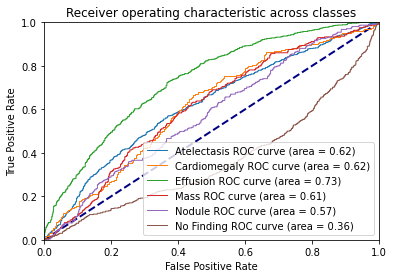

In [21]:
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

for name in ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Mass', 'Nodule', 'No Finding']: #preds.keys():

    y_test = labels[name]
    y_score = preds[name]

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=1, label= name + ' ROC curve (area = %0.2f)' % roc_auc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic across classes')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# plt.figure()
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# y_test = labels_all
# y_score = preds_all

# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label=1)
# roc_auc = auc(fpr, tpr)

# plt.plot(fpr, tpr, lw=1, label= 'all' + ' ROC curve (area = %0.2f)' % roc_auc)

# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic across classes')
# plt.legend(loc="lower right")
# plt.show()

In [ ]:
# plt.figure()
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# for name in preds.keys():

#     y_test = labels[name]
#     y_score = preds[name]

#     fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label=1)
#     roc_auc = auc(fpr, tpr)

#     plt.plot(fpr, tpr, lw=1, label= name + ' ROC curve (area = %0.2f)' % roc_auc)

# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic across classes')
# plt.legend(loc="lower right")
# plt.show()

In [ ]:
preds['Cardiomegaly'][0:10]

In [ ]:
labels['Cardiomegaly'][0:10]

In [ ]:
# preds_t = {}
# labels_t = {}

# for imgs, labs in valid_loader:

#     print('labs.shape =', labs.shape)
#     print('p.shape    =', p.shape)
#     print('labs:       ', labs)
#     print('p:          ', p)
    
    
#     p = model(imgs)
#     p = p.detach().cpu().numpy().reshape(15,)
#     labs = labs.detach().cpu().numpy().reshape(15,)
    
#     print('--alter complete--')
    
#     print('labs.shape =', labs.shape)
#     print('p.shape    =', p.shape)
#     print('labs:       ', labs)
#     print('p:          ', p)
    
#     print('\n---next---\n')
    
#     for name, idx in disease_map.items():
#         preds_t[name] = np.append(preds_t.get(name, np.array([])), p[idx])
#         labels_t[name] = np.append(labels_t.get(name, np.array([])), labs[idx])

# print("loaded all predictions with labels")

In [ ]:
plt.hist(preds['Cardiomegaly'], label='Cardiomegaly')
plt.hist(preds['Effusion'], label='Effusion')
plt.hist(preds['Nodule'], label='Nodule')
plt.hist(preds['Mass'], label='Mass')
plt.hist(preds['Atelectasis'], label='Atelectasis')
plt.legend()

In [ ]:
for name in list(preds.keys()):
    plt.hist(preds[name], label=name)

In [ ]:
cardio_correct = np.array([])
cardio_wrong = np.array([])

for i in range(len(preds['Cardiomegaly'])):
    if labels['Cardiomegaly'][i] == 1:
        cardio_correct = np.append(cardio_correct, preds['Cardiomegaly'][i])
    else:
        cardio_wrong = np.append(cardio_wrong, preds['Cardiomegaly'][i])

In [ ]:
plt.hist(cardio_correct, label='cardio present', alpha=0.8)
plt.hist(cardio_wrong, label='not present', alpha=0.5)

plt.legend()

In [ ]:
preds, labs = next(iter(valid_loader))

In [ ]:
preds = model(preds.cuda())

In [ ]:
preds

In [ ]:
labs[0]

In [ ]:
preds.shape

In [ ]:
labs.shape